In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
# Image size and batch size (optimized for CPU training)
img_size = (128, 128)   
batch_size = 8          

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "images/train",
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical"
)

# Validation data generator (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    "images/Validation",
    target_size=img_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [14]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3),
    pooling="avg",
    alpha=0.5   # make model lighter/faster
)

# Freeze base model for feature extraction
base_model.trainable = False

3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(train_generator.num_classes, activation="softmax")(x)

# Final model
model = models.Model(inputs=base_model.input, outputs=output)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

callbacks = [early_stop, lr_reduce]

In [35]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 394s 109ms/step - accuracy: 0.4405 - loss: 1.5058 - val_accuracy: 0.4292 - val_loss: 1.5166 - learning_rate: 3.9063e-06
Epoch 2/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 342s 95ms/step - accuracy: 0.4334 - loss: 1.5167 - val_accuracy: 0.4309 - val_loss: 1.5161 - learning_rate: 3.9063e-06
Epoch 3/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 332s 92ms/step - accuracy: 0.4396 - loss: 1.5173 - val_accuracy: 0.4302 - val_loss: 1.5158 - learning_rate: 3.9063e-06
Epoch 4/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 331s 92ms/step - accuracy: 0.4369 - loss: 1.5056 - val_accuracy: 0.4288 - val_loss: 1.5185 - learning_rate: 3.9063e-06
Epoch 5/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 343s 95ms/step - accuracy: 0.4323 - loss: 1.5234 - val_accuracy: 0.4304 - val_loss: 1.5159 - learning_rate: 3.9063e-06
Epoch 6/20
3603/3603 ━━━━━━━━━━━━━━━━━━━━ 347s 96ms/step - accuracy: 0.4340 - loss: 1.5137 - val_accuracy: 0.4316 - val_loss: 1.5119 - learning_rate: 1.9531e-06
Epoch 7/20
3603/3603 ━━━━━━━━━━━━

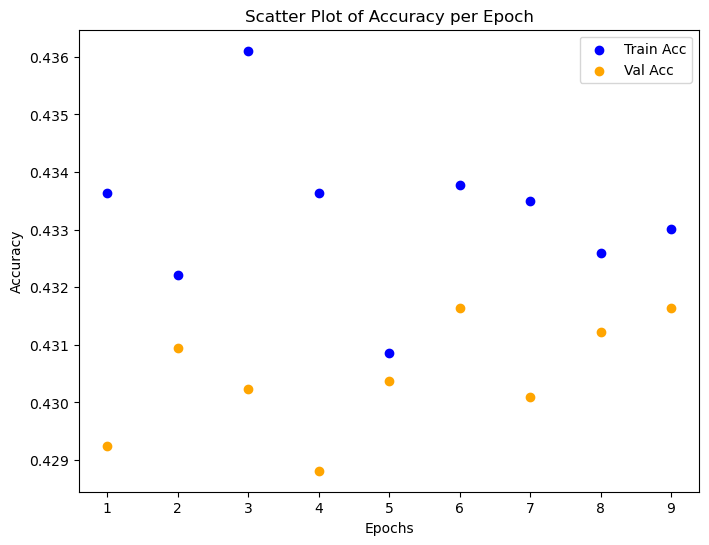

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(range(1, len(history.history['accuracy'])+1), history.history['accuracy'],
            label='Train Acc', c='blue')
plt.scatter(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'],
            label='Val Acc', c='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Scatter Plot of Accuracy per Epoch")
plt.legend()
plt.show()

884/884 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step


C:\Users\udana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\udana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.52      0.06      0.11       960
     disgust       0.00      0.00      0.00       111
        fear       0.33      0.11      0.17      1018
       happy       0.59      0.66      0.62      1825
     neutral       0.41      0.43      0.42      1216
         sad       0.28      0.65      0.39      1139
    surprise       0.62      0.50      0.55       797

    accuracy                           0.43      7066
   macro avg       0.39      0.35      0.32      7066
weighted avg       0.46      0.43      0.40      7066



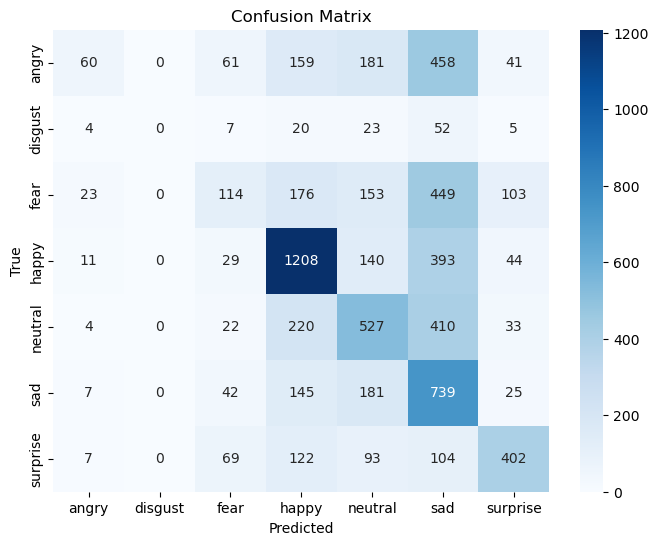

In [37]:
# Reset generator before prediction
val_generator.reset()

# True labels
y_true = val_generator.classes

# Predictions
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes,
                            target_names=list(val_generator.class_indices.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


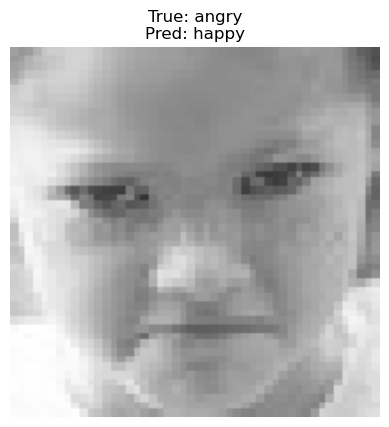

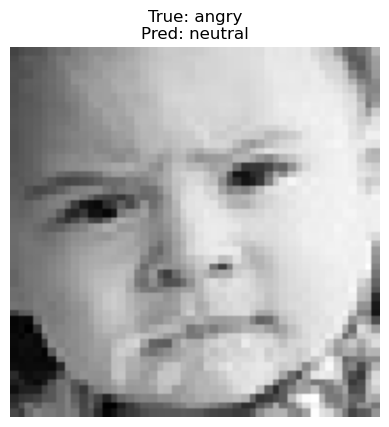

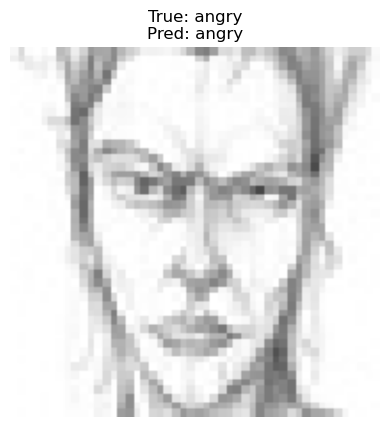

In [39]:
# Get one batch of images from validation
sample_batch, sample_labels = next(val_generator)

# Predict
preds = model.predict(sample_batch)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

# Show first 3 images with true & predicted labels
for i in range(3):
    plt.imshow(sample_batch[i])
    plt.title(f"True: {list(val_generator.class_indices.keys())[true_classes[i]]}\n"
              f"Pred: {list(val_generator.class_indices.keys())[pred_classes[i]]}")
    plt.axis("off")
    plt.show()

In [41]:
model.save("facial_expressions_model_MobileNetV2.h5")
print("Model saved")

Model saved
